# Crack Me If You Can 2023 Example Notebook

### Introduction
This Jupyter Notebook has been set up to demonstrate how to use this framework. Think of it as a training lesson. Feel free to modify this to fit your own needs or create your own Notebooks to better fit your workflow.

If you edit the core python classes are stored in .py files in lib_framework, you will need to reload the kernel for this workbook for those changes to be applied. You can do this by clicking on the "fast forward (two arrows)" button in the top ribbon above this. That being said, you can access all of the class datastructures in the cells below and write your own code to parse them. The code in the cells will be applied when you run that cell, which makes it very easy to run some quick tests on the underlying data without having to reload everything.

Once you modify the config.yml file to fit your environment, feel free to hit the "fast forward" button to run this whole notebook. Or you can step through each cell one by one and run it. Whatever works best for you. This notebook was designed to be run sequentally though, so if you start running these cells out of order you may find required data hasn't been loaded yet.

### Loading the configuration and the initial challenge files

Core information about your cracking session is stored in the SessionMgr (Session Manager) class. The SessionMgr handles storing information about password hashes, password metadata, password plaintext values, and information about your cracking setup. The cracking setup contains information about your John the Ripper and Hashcat configurations, as well as the various potfiles you may be managing. This means the SessionMgr fills two different use-cases:
1. Performing analysis on cracked passwords and uncracked password metadata
2. Managing and automating many of the password cracking tasks you may have like syncing pot files between multiple different sessions.

To that end, by default SessionMgr will load and parse all of the challenge files listed in your config file. This can take a couple of minutes sometimes, so if you want to use this to automate your workflow and not perform analysis you can instead call the init function using **SessionMgr(config_file, load_challenge=False)** If you do this it will not load the password hashes, but you can still use it to sync your password files (Ed. Note: This is a TBD feature and not fully implimented yet).

The awesome thing about JupyterLab is you only need to load this data once, (unless it changes). You can then update and rerun the cells after this as many times as you want while still referencing the data collected here. This can save you a ton of time since you don't need to wait a couple of minutes to re-load all the data if you are performing simple graphing, analysis, and pot file management.

In the example below, it initializes the SessionMgr to load everything including challenge hashes.

In [1]:
from lib_framework.session_mgr import SessionMgr

config_file = "config.yml"

sm = SessionMgr(config_file)

Starting to load challenge yaml file. This may take a minute or two


### Loading cracked passwords (Pot Files)

The next step is to load all the cracked passwords (Pot Files). One for John the Ripper cracking sessions, and the other for Hashcat cracking sessions. The format for these files is slighly different which is why they are not combined. The main pot files are specified in the config file that you loaded earlier. These pot files should be unique for this contest and not contain cracked passwords from your day job. Also I'd recommend against loading/updating them if you have current password cracking sessions being run that are writing to them since I don't know how to properly lock those files without interfearing with running cracking sessions.

After both pot files are loaded, the next step is to update them with cracked passwords found in the other pot files. This will be helpful so you aren't cracking the same salted password twice, and the new plaintexts can be leveraged in loopback attacks.

In [2]:
sm.load_main_pots(verbose=False)
sm.update_main_pots()

Number of new plains added to the JtR pot file: 0
Number of new plains added to the Hashcat pot file: 0


### Understanding Current Status

The **ServiceMgr.print_status()** command is one you'll likely be running a lot as it'll provied a high level view of what you've cracked, and what hash types you have remaining. This won't update automatically, so you'll need to re-run this cell after you load new cracks into the framework.

In [3]:
sm.print_status()

Algorithm     :Total      :Cracked   :Remaining :Percentage
md5crypt       :20        :1         :19        :5%
ssha           :21        :0         :21        :0%
bcrypt         :13        :0         :13        :0%
raw-md5        :10        :1         :9         :10%
raw-sha256     :19        :0         :19        :0%
sha256crypt    :15        :1         :14        :7%
raw-sha1       :19        :2         :17        :11%
ssha512        :11        :0         :11        :0%
sha1crypt      :10        :0         :10        :0%


### First Pass: Understanding the Metadata

It's helpful to know what metadata was loaded up with the challenge file. The **ServiceMgr.print_metadata_categories** will show the top level metadata categories you can search on and graph.

In [4]:
sm.print_metadata_categories()

Metadata Type       :Count
Created             :138
City                :112
Company             :138
Department          :136
GivenName           :133
SurName             :135
Phone               :135


### Creating Graphs and Performing Data Analysis

The real reason to use JupyterLab is to create cool looking graphs! One thing I'm trying to do with this framework is make it easier to create the graphs that will be helpful during a password cracking session. The first built-in graphing function I created was to generate a pie graph of the metadata. 

**ServiceMgr.pie_graph_metadata(metaData_field, has_plaintext, top_x, plot_size)**

You can specify any field name for metadata and then specify if you want to print the percentage of the total set, or just the percentage that has cracked passwords. As a side note, I'm also disabling warnings below since the non-ASCII department names KoreLogic created can cause a bunch of warnings to pop up.

First, let's print a pie graph of the number of password hashes for each Department.

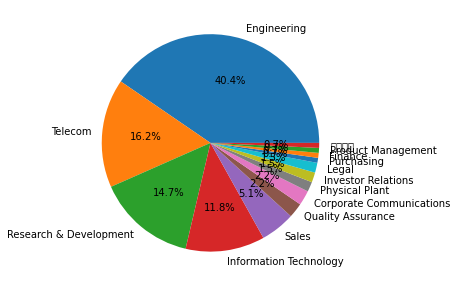

In [5]:
import warnings
warnings.filterwarnings('ignore')

sm.pie_graph_metadata("Department")

That's hard to read. It might be nice to only graph the top five items. So I added in the **top_x** variable you can pass the pie_graph_metadata function. Here is a nicer graph:

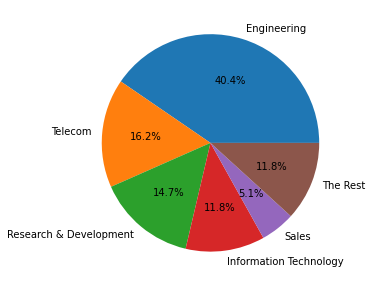

In [6]:
sm.pie_graph_metadata("Department", top_x=5)

Now let's print a pie graph showing the same pie chart, but only including hashes that we've cracked passwords for. This can be very useful to see where your current attacks might be targeting as well as how to then optimize the computationally expensive hashes you target. For example in my write-up I had found that a vast majority of my cracks in the 2023 CMIYC competition were for the Sales department.

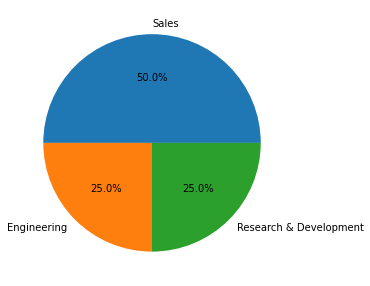

In [7]:
sm.pie_graph_metadata("Department", has_plaintext=True, top_x=5)

Of course, it might be nice to increase or decresase the size fo the chart as well. You can do that with the **plot_size** variable.

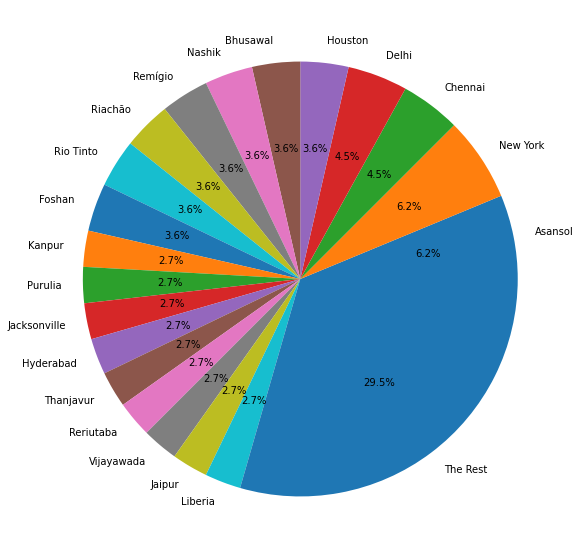

In [8]:
sm.pie_graph_metadata("City", top_x=20, plot_size=10)

### Digging Into The Raw Numbers

Graphs can be pretty, and can spark new ideas, but sometimes you want to the see the raw numbers and values. If you call the function **ServiceMgr.print_metadata_items(meta_field}**. This prints out the total number of hashes and cracked hashes for each metadata field you specify.

In [10]:
sm.print_metadata_items("Department")

Department              :Count :Cracked
Information Technology  :16    :0
Engineering             :55    :1
Quality Assurance       :3     :0
Telecom                 :22    :0
Research & Development  :20    :1
Corporate Communications:3     :0
Physical Plant          :2     :0
Purchasing              :1     :0
Sales                   :7     :2
Investor Relations      :2     :0
Finance                 :1     :0
Product Management      :1     :0
Legal                   :2     :0
質量保證                    :1     :0
